In [1]:
%matplotlib inline
%time from hikyuu.interactive import *

2024-05-19 01:00:04,226 [INFO] hikyuu version: 2.0.7_202405181604_RELEASE_windows_x64 [<module>] (D:\workspace\hikyuu\hikyuu\__init__.py:97) [hikyuu::hku_info]


2024-05-19 01:00:04.658 [HKU-I] - Using MYSQL BaseInfoDriver (BaseInfoDriver.cpp:58)
2024-05-19 01:00:04.685 [HKU-I] - Loading market information... (StockManager.cpp:538)
2024-05-19 01:00:04.702 [HKU-I] - Loading stock type information... (StockManager.cpp:551)
2024-05-19 01:00:04.717 [HKU-I] - Loading stock information... (StockManager.cpp:466)
2024-05-19 01:00:04.870 [HKU-I] - Loading stock weight... (StockManager.cpp:568)
2024-05-19 01:00:06.193 [HKU-I] - Loading KData... (StockManager.cpp:134)
2024-05-19 01:00:07.724 [HKU-I] - Preloading all day kdata to buffer! (StockManager.cpp:172)
2024-05-19 01:00:07.724 [HKU-I] - Preloading all week kdata to buffer! (StockManager.cpp:175)
2024-05-19 01:00:07.724 [HKU-I] - Preloading all month kdata to buffer! (StockManager.cpp:178)
2024-05-19 01:00:07.729 [HKU-I] - 1.54s Loaded Data. (StockManager.cpp:151)
CPU times: total: 422 ms
Wall time: 4.27 s


In [2]:
start_date = Datetime(20200101)
end_date = None
query = Query(start_date, end_date)

Text(0.5, 1.0, '平安银行')

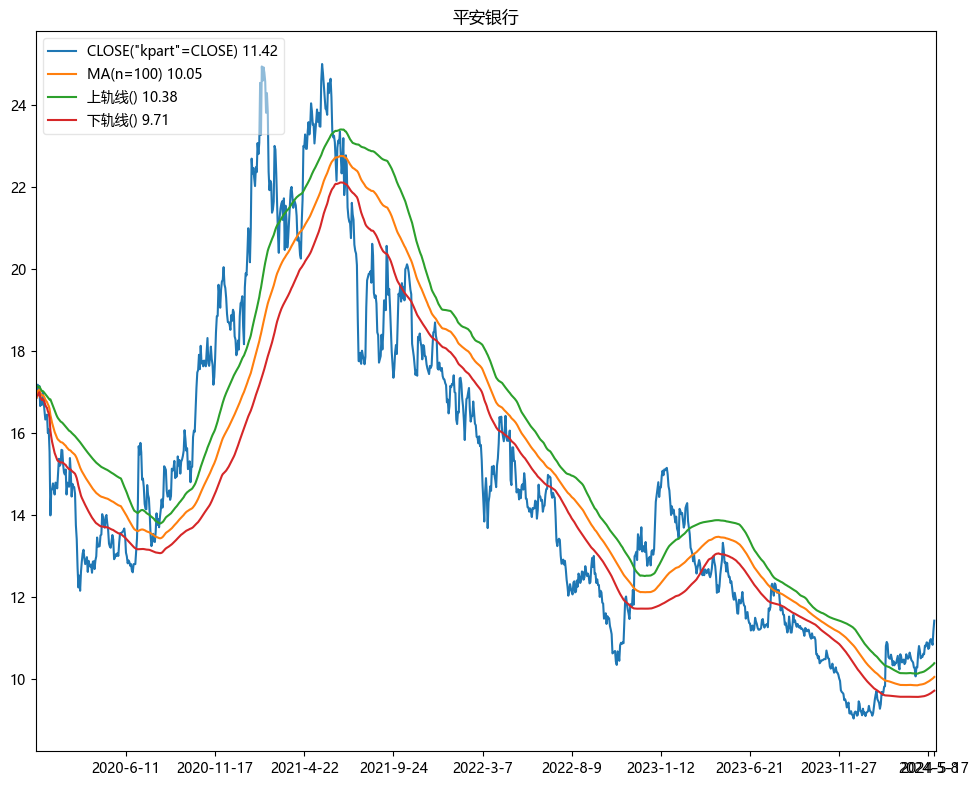

In [6]:
stk = sm['sz000001']
k = stk.get_kdata(query)
n = 100
band = 0.5

c = CLOSE()
ma = MA(CLOSE, n)
upper = ma + band * STDEV(CLOSE, n)
upper.name = "上轨线"
lower = ma - band * STDEV(CLOSE, n)
lower.name = "下轨线"

c(k).plot(legend_on=True)
ma(k).plot(new=False, legend_on=True)
upper(k).plot(new=False, legend_on=True)
lower(k).plot(new=False, legend_on=True)
gca().set_title(stk.name)

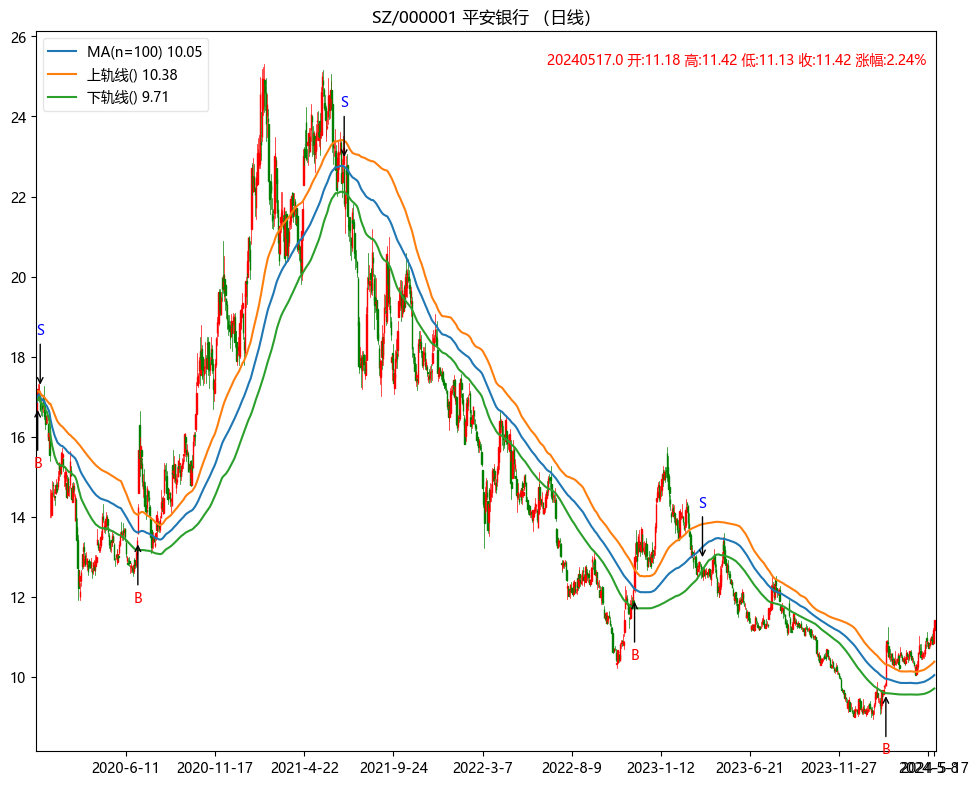

In [7]:
# 使用 crtSG 方法快速创建 SG
def bulindai_calculate(self: SignalBase, k: KData):
    n = self.get_param("n")
    band = self.get_param("band")
    top = (MA(CLOSE, n) + band * STDEV(CLOSE, n))(k)
    bottom = (MA(CLOSE, n) - band * STDEV(CLOSE, n))(k)
    c = k.close
    for i in range(top.discard, len(top)):
        if c[i] > top[i]:
            self._add_buy_signal(k[i].datetime)
        elif c[i] < bottom[i]:
            self._add_sell_signal(k[i].datetime)

# 创建 SG 实例
my_sg = crtSG(bulindai_calculate, params={"n": n, "band": band}, name="趋势布林带")

# 绘制 sg
# sg 只有指定了交易对象才会进行实际计算，通常由 SYS 实例执行回测时自动设定
my_sg.to = k  
my_sg.plot()
ma(k).plot(new=False, legend_on=True)
upper(k).plot(new=False, legend_on=True)
lower(k).plot(new=False, legend_on=True)

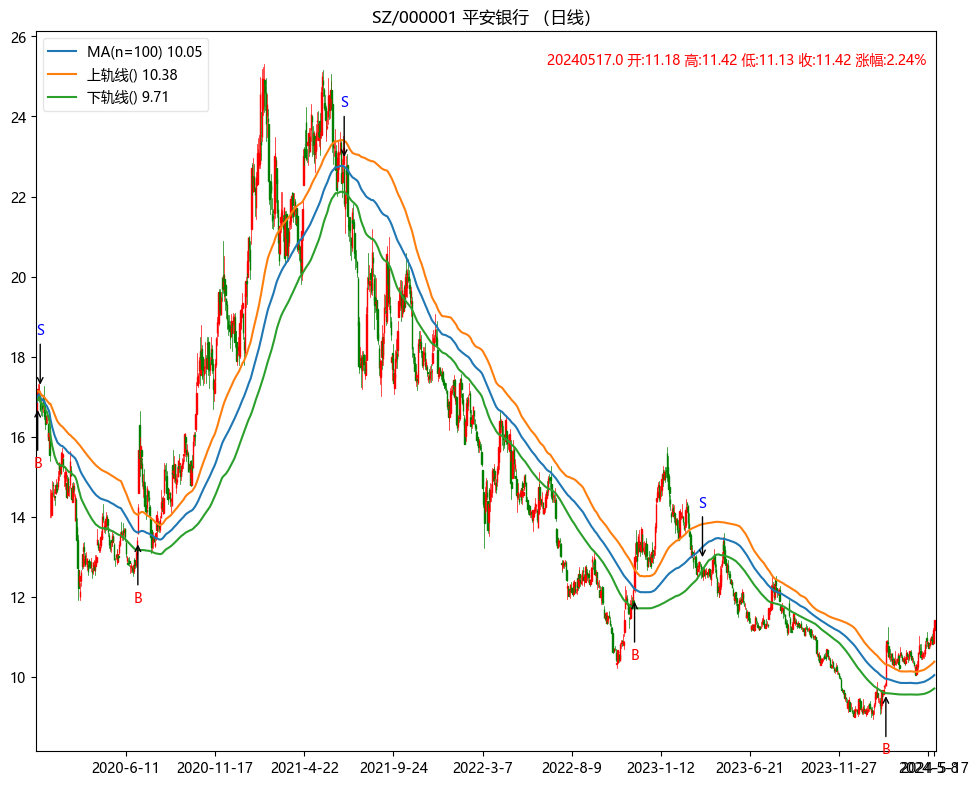

In [8]:
# 使用常规的类继承方式实现信号指示器
class SG_BuLin(SignalBase):
    def __init__(self, n=100, band=0.5):
        super(SG_BuLin, self).__init__("SG_BuLin")
        self.set_param("n", int(n))
        self.set_param("band", float(band))

    def _calculate(self, k):
        n = self.get_param("n")
        band = self.get_param("band")
        c = k.close
        ma = MA(c, n)
        sd = STDEV(c, n)
        top = ma + band * sd
        bottom = ma - band * sd
        for i in range(len(c)):
            if c[i] > top[i]:
                self._add_buy_signal(k[i].datetime)
            elif c[i] < bottom[i]:
                self._add_sell_signal(k[i].datetime)

    def _clone(self):
        cloned = SG_BuLin(self.get_param("n"), self.get_param("band"))
        return cloned
    
# 创建 SG 实例
my_sg = SG_BuLin(n=n, band=band)

# 绘制 sg
# sg 只有指定了交易对象才会进行实际计算，通常由 SYS 实例执行回测时自动设定
my_sg.to = k  
my_sg.plot()
ma(k).plot(new=False, legend_on=True)
upper(k).plot(new=False, legend_on=True)
lower(k).plot(new=False, legend_on=True)

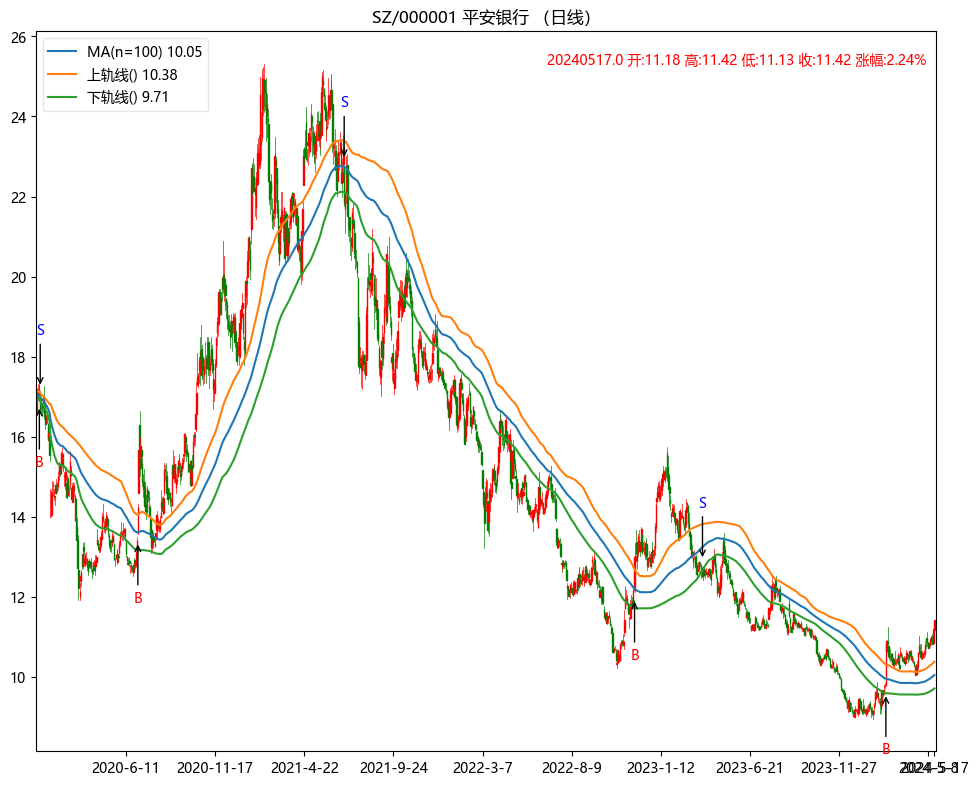

In [14]:
buyind = CROSS(CLOSE, upper)
sellind = CROSS(lower, CLOSE)
my_sg = SG_Bool(buyind, sellind)

my_sg.to = k  
my_sg.plot()
ma(k).plot(new=False, legend_on=True)
upper(k).plot(new=False, legend_on=True)
lower(k).plot(new=False, legend_on=True)

In [20]:
# stks = [s for s in blocka if s.valid and s.start_datetime < start_date]
stks = [s for s in sm if s.valid and s.type == constant.STOCKTYPE_ETF]
print(len(stks))
my_sys = get_part("start.sys.趋势布林带")
# my_sys.sg.set_param("alternate", False)
# my_sys.mm = MM_FixedCount(1000)

780


In [21]:
%time df = analysis_sys_list(stks, query, my_sys)

CPU times: total: 46.9 ms
Wall time: 203 ms


In [22]:
df[df['当前总资产'] > 100000]

,证券代码,证券名称,累计投入本金,当前总资产,现金余额,未平仓头寸净值,赢利交易比例%,赢利交易数,亏损交易数
0,SH513100,纳指ETF,100000.0,178456.0,951.0,177505.0,60.000000,6.0,4.0
3,SH512400,有色金属ETF,100000.0,133573.0,352.0,133221.0,25.000000,2.0,6.0
4,SH515210,钢铁ETF,100000.0,125498.0,561.0,124937.0,14.285714,1.0,6.0
6,SH512560,军工ETF易方达,100000.0,107561.0,446.0,107115.0,25.000000,2.0,6.0
7,SH515150,一带一路ETF,100000.0,119073.0,609.0,118464.0,42.857143,3.0,4.0
...,...,...,...,...,...,...,...,...,...
770,SH513910,港股央企红利ETF,100000.0,117123.0,897.0,116226.0,0.000000,0.0,1.0
771,SZ159593,中证A50指数ETF,100000.0,101750.0,94.0,101656.0,50.000000,1.0,1.0
773,SH513210,恒生ETF易方达,100000.0,116366.0,432.0,115934.0,0.000000,0.0,0.0
774,SZ159307,红利低波100ETF,100000.0,103030.0,212.0,102818.0,0.000000,0.0,0.0


In [23]:
df[df['当前总资产'] < 100000]

,证券代码,证券名称,累计投入本金,当前总资产,现金余额,未平仓头寸净值,赢利交易比例%,赢利交易数,亏损交易数
1,SH510050,上证50ETF,100000.0,97917.0,599.0,97318.0,12.500000,1.0,7.0
2,SZ159736,饮食ETF,100000.0,85628.0,608.0,85020.0,0.000000,0.0,7.0
5,SH517880,品牌消费ETF,100000.0,89110.0,129.0,88981.0,14.285714,1.0,6.0
8,SH512640,金融地产ETF基金,100000.0,90074.0,962.0,89112.0,18.181818,2.0,9.0
10,SH515960,医药健康ETF,100000.0,84984.0,561.0,84423.0,14.285714,1.0,6.0
...,...,...,...,...,...,...,...,...,...
765,SZ159530,机器人100ETF,100000.0,95173.0,45.0,95128.0,50.000000,1.0,1.0
767,SH513400,道琼斯ETF,100000.0,96039.0,807.0,95232.0,0.000000,0.0,3.0
768,SZ159529,标普消费ETF,100000.0,99475.0,523.0,98952.0,0.000000,0.0,1.0
772,SZ159586,计算机ETF南方,100000.0,98157.0,98157.0,0.0,0.000000,0.0,1.0


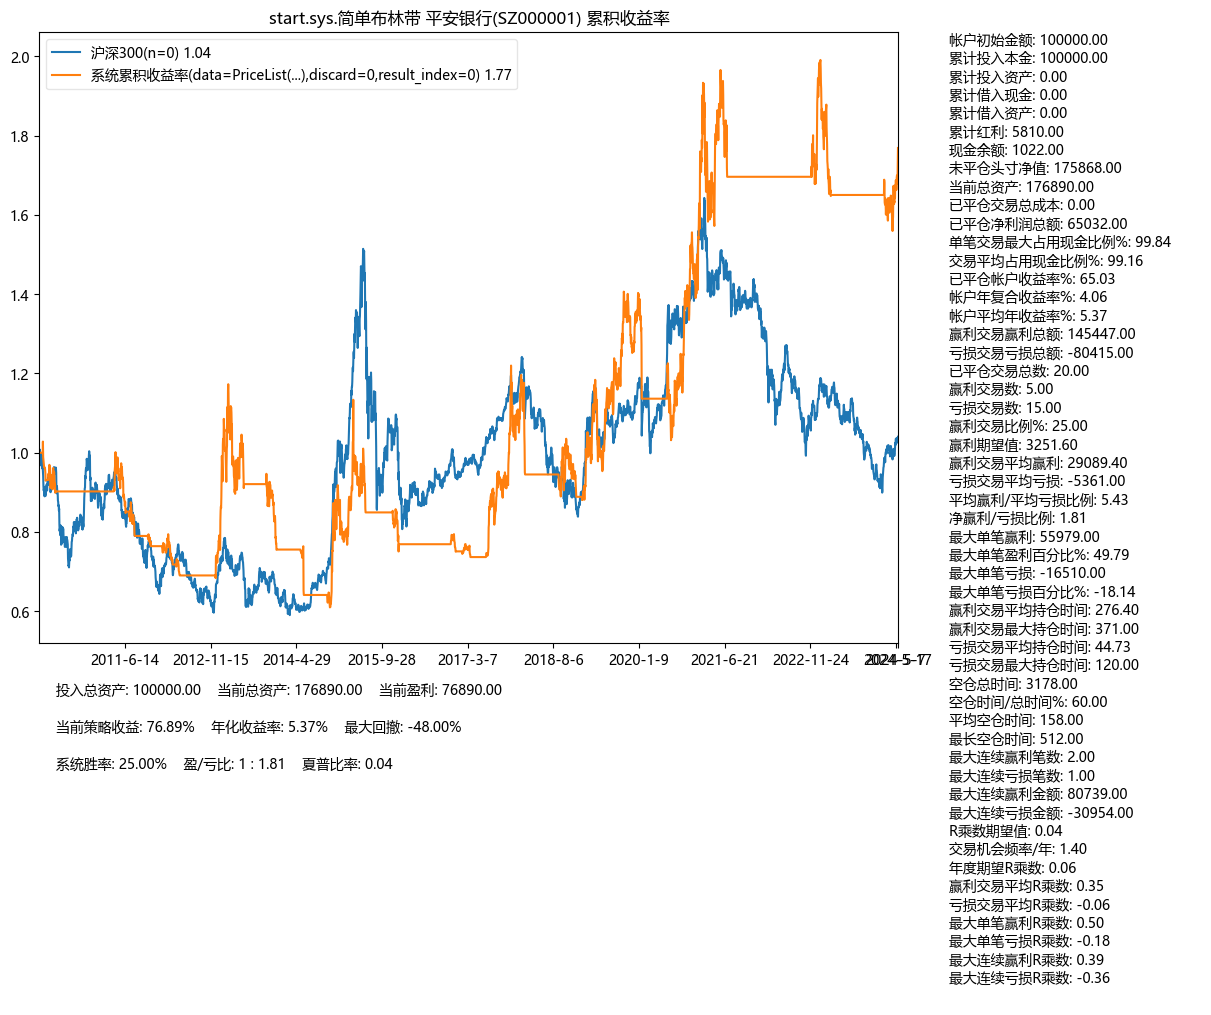

In [36]:
my_sys = get_part("start.sys.简单布林带")
my_sys.run(sm['sz000001'], query)
my_sys.performance()